Split Operation and Merge Operation:
1.   Merge - Well Posed
2.   Split - Ill Posed

In [ ]:
import numpy as np
import math

def merge (pi_1, mean_1, sigma_1, pi_2, mean_2, sigma_2):
  pi = pi_1 + pi_2
  mean_1[0] = np.array(mean_1[0])
  mean_2[0] = np.array(mean_2[0])
  mean_1 = np.array(mean_1)[np.newaxis]
  mean_2 = np.array(mean_2)[np.newaxis]
  mean = pi_1 * mean_1[0] + pi_2 * mean_2[0]
  mean /= pi
  sigma  = pi_1 * ( sigma_1[0] + np.matmul( mean_1, mean_1.T )) + pi_2 * ( sigma_2[0] + np.matmul( mean_2, mean_2.T ))
  sigma /= pi
  sigma -= np.matmul ( mean, mean.T )

  return pi,mean,sigma

def split (pi, mean, sigma, n):
  alpha = 0.5
  beta = 0.5
  mu = 0.5

  pi_1 = pi * alpha
  pi_2 = pi * (1 - alpha)

  #covariance matrix split using cholesky decomposition
  L = np.linalg.cholesky(sigma)
  sqrt_mean_estimate = math.sqrt(pi_2/pi_1)

  diag=[]
  for i in range(n):
    list1=[] 
    for j in range(n):
      if(i!=j):
        list1.append(0)
      else:
        list1.append(sqrt_mean_estimate)
    diag.append(list1)

  diag[0][0] = diag[0][0] * math.sqrt(beta*(1-mu**2))
  L_1 = np.matmul(L.T,diag)

  diag[0][0] = diag[0][0] * math.sqrt((1-beta)/(beta))
  L_2 = np.matmul(L.T,diag)

  mean_1 = mean - sqrt_mean_estimate  * mu * L[0]
  mean_2 = mean + (1/sqrt_mean_estimate) * mu * L[0]

  sigma_1 = (sqrt_mean_estimate**2)*sigma[0] + (beta - beta*(mu**2) - 1)*(pi/pi_1)*np.matmul(L[0],L[0].T) + np.matmul(L[0],L[0].T)
  sigma_2 = (pi_1/pi_2)*sigma[0] + (beta*(mu**2) - beta - (mu**2)) * (pi / pi_2)*np.matmul(L[0],L[0].T) + np.matmul(L[0],L[0].T)

  return pi_1, mean_1, [sigma_1], pi_2, mean_2, [sigma_2] 

Criterion for Split and Merge:
1.   Merge - Correlation Coefficient
2.   Split - Local Kullback Divergence



In [ ]:
from numpy import array
from numpy.linalg import norm
from scipy import random
from scipy.stats import multivariate_normal
import numpy as np
import math

#input parameters are the lists of mean, covariances and mixing coefficients of all the components
def merge_criterion(pi, mean, sigma, dataset, n): 
  n_dataset = dataset.shape[0]
  posterior_prob = np.zeros((n_dataset,n))

  for i in range(n):
    posterior_prob[:, i] = pi[i] * multivariate_normal.pdf(dataset, mean=mean[i], cov=sigma[i])
  posterior_prob /= posterior_prob.sum(axis=1, keepdims=True)

  j_merge = np.zeros((n,n))
  max_merge = 0
  index_i = -1
  index_j = -1
  for i in range(n):
    for j in range(n):
      if(i!=j):
        j_merge[i][j] = np.matmul(posterior_prob[i].T, posterior_prob[j])/(norm(posterior_prob[i])*norm(posterior_prob[j]))
        if( max_merge < j_merge[i][j] ):
          max_merge = j_merge[i][j]
          index_i = i
          index_j = j
  
  return max_merge, index_i, index_j

#calculating the likelihood of split and comparing it with threshold
def split_criterion(pi, mean, sigma, dataset, n, o): 
  max_likelihood = 0
  '''diameter = []
  for i in range(o):
    diameter[i] = 0
    for j in range(o):
      if(norm(dataset[j]-dataset[i])>diameter[i]):
        diameter[i] = norm(dataset[j]-dataset[i])
  
  for i in range(n):
    posterior_prob[:, i] = pi[i] * multivariate_normal.pdf(dataset, mean=mean[i], cov=sigma[i])

  max_split = 0
  for i in range(n):
    for j in range(o):
      local_data_density[i] += norm(dataset[j]-dataset[i]) * posterior_prob[j][i]
    local_data_density[i] /= posterior_prob.sum(axis=1, keepdims=True)

  for i in range(n):
    for j in range(o):
      j_split[i] += local_data_density[]'''

  return max_likelihood

Evaluating Likelihood

In [ ]:
import numpy as np
from scipy import random
from scipy.stats import multivariate_normal
import math

def evaluate_likelihood( pi, mean, sigma, dataset, n):
  likelihood = []
  for d in dataset:
    total = [0]
    for i in range(n):
      total.append(pi[i] * multivariate_normal.pdf(d, mean=mean[i], cov=sigma[i]))
      likelihood.append(np.log(np.sum(total)))
  return np.sum(likelihood)

EM Algorithm ( With / Without Simulated Annealing )

In [ ]:
import numpy as np
import random
from scipy import random
from scipy.stats import multivariate_normal

class em():
    def __init__(self, k, dim, i_mean=None, i_sigma=None, i_pi=None):
        self.k = k
        self.dim = dim
        if(i_mean is None):
            i_mean = random.rand(k, dim)*50 - 25
        self.mean = i_mean
        if(i_sigma is None):
            i_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                i_sigma[i] = np.eye(dim)
        self.sigma = i_sigma
        if(i_pi is None):
            i_pi = np.ones(self.k)/self.k
        self.pi = i_pi
    
    def i_em(self, X):
        self.ds = X
        self.n = X.shape[0]
        self.z = np.zeros((self.n, self.k))
    
    def e_step(self):
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(self.ds, mean=self.mean[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)
    
    def m_step(self):
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.n
        self.mean = np.matmul(self.z.T, self.ds)
        self.mean /= sum_z[:,None]
        for i in range(self.k):
            j = np.expand_dims(self.ds, axis=1) - self.mean[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
        print("Mean: ")
        print(self.mean)
        print("\nCovariance: ")
        print(self.sigma)
        print("\nMixing Coeff.: ")
        print(self.pi)
        return self.mean, self.sigma, self.pi
            
    def llh(self, X):
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mean[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)

class sa_em():
    def __init__(self, k, dim, i_mean=None, i_sigma=None, i_pi=None):
        self.k = k
        self.dim = dim
        if(i_mean is None):
            i_mean = random.rand(k, dim)*50 - 25
        self.mean = i_mean
        if(i_sigma is None):
            i_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                i_sigma[i] = np.eye(dim)
        self.sigma = i_sigma
        if(i_pi is None):
            i_pi = np.ones(self.k)/self.k
        self.pi = i_pi
        self.AnnIter = 2000
        self.tau = 0.05
        self.e = 1e-5
        self.temp = self.tau
        self.iter = 1

    
    def i_em(self, X):
        self.ds = X
        self.n = X.shape[0]
        self.z = np.zeros((self.n, self.k))
    
    def e_step(self):
        s = self.pi/max(self.pi)
        rnd = random.uniform(0,1)
        for i in range(self.k):
          if((rnd<self.temp) and (self.iter<self.AnnIter)):
            self.z[:, i] = (self.pi[i] * multivariate_normal.pdf(self.ds, mean=self.mean[i], cov=self.sigma[i]))**s[i]
          else:
            self.z[:, i] = (self.pi[i] * multivariate_normal.pdf(self.ds, mean=self.mean[i], cov=self.sigma[i])) 
        self.z /= self.z.sum(axis=1,keepdims=True) 
        sum_z = self.z.sum(axis=0)

        for i in range(self.k):
          self.pi[i] = sum_z[i]/self.n
        #self.z /= self.z.sum(axis=1, keepdims=True)

        self.mean = np.matmul(self.z.T, self.ds)
        self.mean /= sum_z[:,None]

        for i in range(self.k):
          j = np.expand_dims(self.ds, axis=1) - self.mean[i]
          s = np.matmul(j.transpose([0, 2, 1]), j)
          self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
          self.sigma[i] /= sum_z[i]
          self.sigma[i] += np.eye(self.dim)*(1e-4)
          self.pi/=self.pi.sum(axis=0)
        print("Mean: ")
        print(self.mean)
        print("\nCovariance: ")
        print(self.sigma)
        print("\nMixing Coeff.: ")
        print(self.pi)
        return self.mean, self.sigma, self.pi
    
    def m_step(self):
        sum_z = self.z.sum(axis=0)
        self.pi = sum_z / self.n
        self.mean = np.matmul(self.z.T, self.ds)
        self.mean /= sum_z[:,None]
        for i in range(self.k):
            j = np.expand_dims(self.ds, axis=1) - self.mean[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i] )
            self.sigma[i] /= sum_z[i]
            self.sigma[i] += np.eye(self.dim)*(1e-4)
        print("Mean: ")
        print(self.mean)
        print("\nCovariance: ")
        print(self.sigma)
        print("\nMixing Coeff.: ")
        print(self.pi)
        return self.mean, self.sigma, self.pi

    def update(self):
        if(self.iter>1):
          if(abs((em.llh(self,self.ds)/self.tmp)-1)<self.e and self.iter>self.AnnIter):
            self.check = 1
            return 1
        self.temp = max(0, self.tau - self.tau*self.iter/self.AnnIter)
        self.iter = self.iter+1
        self.tmp = em.llh(self,self.ds)
        return 0
            
    def llh(self, X):
        ll = []
        for d in X:
            tot = 0
            for i in range(self.k):
                tot += self.pi[i] * multivariate_normal.pdf(d, mean=self.mean[i], cov=self.sigma[i])
            ll.append(np.log(tot))
        return np.sum(ll)

Generating Dataset

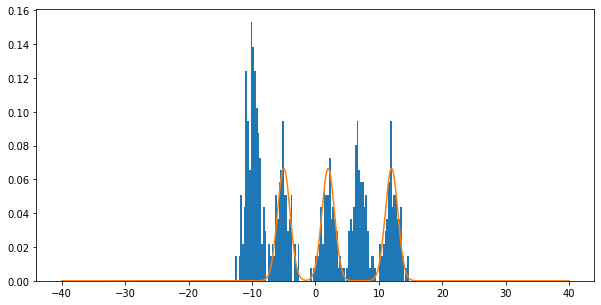

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# stored as array the values of mean and SDs and mixing coefficients
# N1[2/3,-1,1] N2[1/6,0,1], N3[1/6,1,1]
mu = [12,-5, 2, 7,-10]
sigma = [1, 1, 1, 1, 1]
p_i = [1/6, 1/6, 1/6, 1/6, 1/3]
n = 500

# empty array
x = []
for i in range(n):
    z_i = np.argmax(np.random.multinomial(1, p_i))
    x_i = np.random.normal(mu[z_i], sigma[z_i])
    x.append(x_i)

X = np.array(x)
X = np.reshape(X,(n,-1))
def univariate_normal(x, mean, variance):
    return ((1. / np.sqrt(2 * np.pi * variance)) * np.exp(-(x - mean)**2 / (2 * variance)))

a = np.arange(-40, 40, 0.01)
y = p_i[0] * univariate_normal(a, mean=mu[0], variance=sigma[0]**2) + p_i[1] * univariate_normal(a, mean=mu[1], variance=sigma[0]**2)+ p_i[2] * univariate_normal(a, mean=mu[2], variance=sigma[0]**2)

fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(x, bins=100, density=True)
ax.plot(a, y)

EM Algorithm Simulation / SAEM Algorithm Simulation

In [ ]:
def em_simulate(n_cluster, mean, sigma, pi, dataset):
  gmm = em(n_cluster, dim, mean, sigma, pi)
  gmm.i_em(dataset)
  n_iter = 30
  # Saving log-likelihood
  log_likelihood = [gmm.llh(X)]
  for e in range(n_iter):
    # E-step
    gmm.e_step()
    print("Iteration: {}".format(e+1))
    # M-step
    mean, sigma, pi = gmm.m_step()
    # Computing log-likelihood
    log_likelihood.append(gmm.llh(X))
    #print("\nlog-likelihood: {:.8f}".format(log_likelihood[-1]))
    #print("\n")

  return mean, sigma, pi

def saem_simulate(n_cluster, mean, sigma, pi, dataet):
  sa_gmm = sa_em(n_cluster, dim, mean, sigma, pi)
  sa_gmm.i_em(dataset)
  n_iter = 100
  # Saving log-likelihood
  log_likelihood = [gmm.llh(X)]
  for e in range(n_iter):
    # E-step
    gmm.e_step()
    print("Iteration: {}".format(e+1))
    # M-step
    #gmm.m_step()
    z = gmm.update()
    if(z==1):
       break
    # Computing log-likelihood
    log_likelihood.append(gmm.llh(X))
    #print("\nlog-likelihood: {:.8f}".format(log_likelihood[-1]))
    #print("\n")

GMM Split and Merge Algorithm 

In [ ]:
N = 5
k = 2                                           #N-number of iterations
dim = X.shape[1]
n_dataset = X.shape[0]
split_threshold = 0.06
merge_threshold = 0.999999
gmm = em(k,dim)
gmm.i_em(X)

'''
n_iter = 100
# Saving log-likelihood
log_likelihood = [gmm.llh(X)]
for e in range(n_iter):
    # E-step
    mean,sigma,pi = gmm.e_step()
    print("Iteration: {}".format(e+1))
    # M-step
    #gmm.m_step()
    z = gmm.update()
    if(z==1):
       break
    # Computing log-likelihood
    log_likelihood.append(gmm.llh(X))
    print("\nlog-likelihood: {:.8f}".format(log_likelihood[-1]))
    print("\n")
'''

n_iter = 30
# Saving log-likelihood
log_likelihood = [gmm.llh(X)]
for e in range(n_iter):
  # E-step
  gmm.e_step()
  print("Iteration: {}".format(e+1))
    # M-step
  mean, sigma, pi = gmm.m_step()
    # Computing log-likelihood
  log_likelihood.append(gmm.llh(X))
    #print("\nlog-likelihood: {:.8f}".format(log_likelihood[-1]))
    #print("\n")

for i in range(N):
  # initialize the parameters for n_clusters = 1
  mean, sigma, pi = em_simulate(k, mean, sigma, pi, X) 

  split_gaussian = [] 
  split_likelihood = []
  max_split_likelihood = 0

  init_likelihood = evaluate_likelihood ( pi, mean, sigma, X, k)
  max_split_likelihood = 0
  index_split = -1
  for j in range(k):
    print(sigma[j])
    slist = split(pi[j], mean[j], [sigma[j]], dim)
    print(slist)
    t_mean = mean
    t_sigma = sigma
    t_pi = pi
    t_mean[j] = slist[1]
    t_sigma[j] = slist[2]
    t_pi[j] = slist[0]
    t_mean = np.insert(t_mean,j,slist[4])     #mean.append(split_gaussian[index_split][4])
    t_sigma = np.insert(t_sigma,j,slist[5])   #np.concatenate((sigma,split_gaussian[index_split][5]))
    t_pi = np.insert(t_pi,j,slist[3])         #np.concatenate((pi,split_gaussian[index_split][3]))
    t_sigma = np.array(t_sigma)[np.newaxis]
    t_sigma = t_sigma.T
    split_gaussian.append(slist)
    '''likelihood = []
    for d in range(n_dataset):
      total = 0
      for e in range(k):
        if(e!=j):
          total += pi[e] * multivariate_normal.pdf(d, mean=mean[e], cov=sigma[e])
          likelihood.append(np.log(total))
      total += split_gaussian[j][0] * multivariate_normal.pdf(d, mean=split_gaussian[j][1], cov=split_gaussian[j][2])
      total += split_gaussian[j][3] * multivariate_normal.pdf(d, mean=split_gaussian[j][4], cov=split_gaussian[j][5])
      likelihood.append(np.log(total))'''
    llh = evaluate_likelihood(t_pi,t_mean,t_sigma,X,k+1)
    split_likelihood.append(llh)
    if(max_split_likelihood > split_likelihood[j]):
      max_split_likelihood = split_likelihood[j]
      index_split = j

  print(max_split_likelihood)
  print(init_likelihood) 
  if(abs(max_split_likelihood-init_likelihood) > split_threshold):
    mean[index_split] = split_gaussian[index_split][1]
    sigma[index_split] = split_gaussian[index_split][2]
    pi[index_split] = split_gaussian[index_split][0]
    mean = np.insert(mean,index_split,split_gaussian[index_split][4])     #mean.append(split_gaussian[index_split][4])
    sigma = np.insert(sigma,index_split,split_gaussian[index_split][5])   #np.concatenate((sigma,split_gaussian[index_split][5]))
    pi = np.insert(pi,index_split,split_gaussian[index_split][3])         #np.concatenate((pi,split_gaussian[index_split][3]))
    sigma = np.array(sigma)[np.newaxis]
    sigma = sigma.T
    k+=1

  print(mean)
  print(sigma)
  print(pi)
  max_merge, index_merge_1, index_merge_2 = merge_criterion(pi, mean, sigma, X, k)
  print(max_merge)
  if(max_merge > merge_threshold):
    #print(mean[index_merge_1])
    #print(mean[index_merge_2])
    p, m, s = merge(pi[index_merge_1], [mean[index_merge_1]], [sigma[index_merge_1]], pi[index_merge_2], [mean[index_merge_2]], [sigma[index_merge_2]])
    pi[index_merge_1] = p
    mean[index_merge_1] = m
    sigma[index_merge_1] = s
    mean = mean.tolist()
    sigma = sigma.tolist()
    pi = pi.tolist()
    pi.pop(index_merge_2)
    mean.pop(index_merge_2)
    sigma.pop(index_merge_2)
    mean = np.array(mean)
    sigma = np.array(sigma)
    pi = np.array(pi)
    k-=1

  print(mean)
  print(sigma)
  print(pi)

#for i in range(k):
  #print(pi[i])
#for i in range(k):
  #print(mean[i])
#for i in range(k):
  #print(sigma[i])





Iteration: 1
Mean: 
[[-2.54038663]
 [12.21790235]]

Covariance: 
[[[51.49796364]]

 [[ 0.60657248]]]

Mixing Coeff.: 
[0.86032406 0.13967594]
Iteration: 2
Mean: 
[[-2.50669723]
 [12.01677845]]

Covariance: 
[[[52.44962793]]

 [[ 0.70430935]]]

Mixing Coeff.: 
[0.86038545 0.13961455]
Iteration: 3
Mean: 
[[-2.56310058]
 [11.94425634]]

Covariance: 
[[[52.04130059]]

 [[ 0.74060875]]]

Mixing Coeff.: 
[0.85634241 0.14365759]
Iteration: 4
Mean: 
[[-2.59990432]
 [11.92170253]]

Covariance: 
[[[51.70275706]]

 [[ 0.75769792]]]

Mixing Coeff.: 
[0.85394897 0.14605103]
Iteration: 5
Mean: 
[[-2.61903759]
 [11.91506641]]

Covariance: 
[[[51.51078405]]

 [[ 0.76659593]]]

Mixing Coeff.: 
[0.85275811 0.14724189]
Iteration: 6
Mean: 
[[-2.62854996]
 [11.9131201 ]]

Covariance: 
[[[51.410931  ]]

 [[ 0.77123678]]]

Mixing Coeff.: 
[0.85218058 0.14781942]
Iteration: 7
Mean: 
[[-2.63323482]
 [11.91252796]]

Covariance: 
[[[51.3605402 ]]

 [[ 0.77361258]]]

Mixing Coeff.: 
[0.85190009 0.14809991]
Iterat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.


Mean: 
[[-2.63777199]
 [11.91221647]]

Covariance: 
[[[51.31086556]]

 [[ 0.77599371]]]

Mixing Coeff.: 
[0.85163127 0.14836873]
[[51.31086556]]
(0.4258156347696149, array([[-6.21935214]]), [array([[38.48314917]])], 0.4258156347696149, array([[0.94380817]]), [array([[38.48314917]])])
[[0.77599371]]
(0.07418436523038516, array([[11.47176394]]), [array([[0.58199528]])], 0.07418436523038516, array([[12.35266899]]), [array([[0.58199528]])])
-6678.37619856621
-3603.8010628851043
[-6.21935214 12.35266899 11.47176394]
[[38.48314917]
 [ 0.58199528]
 [ 0.58199528]]
[0.42581563 0.07418437 0.07418437]
1.0
[-3.59454371 12.35266899]
[[72.40597445]
 [ 0.58199528]]
[0.5        0.07418437]
Iteration: 1
Mean: 
[[-2.33990664]
 [12.07750525]]

Covariance: 
[[54.09356573]
 [ 0.65739974]]

Mixing Coeff.: 
[0.87092704 0.12907296]
Iteration: 2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.



Mean: 
[[-2.47125792]
 [11.96980819]]

Covariance: 
[[52.97195099]
 [ 0.7071672 ]]

Mixing Coeff.: 
[0.86204279 0.13795721]
Iteration: 3
Mean: 
[[-2.55323982]
 [11.93056181]]

Covariance: 
[[52.19112958]
 [ 0.73778702]]

Mixing Coeff.: 
[0.85678959 0.14321041]
Iteration: 4
Mean: 
[[-2.5959302 ]
 [11.91794356]]

Covariance: 
[[51.75842581]
 [ 0.7556749 ]]

Mixing Coeff.: 
[0.85414497 0.14585503]
Iteration: 5
Mean: 
[[-2.61717012]
 [11.91407401]]

Covariance: 
[[51.53467263]
 [ 0.76552899]]

Mixing Coeff.: 
[0.85285765 0.14714235]
Iteration: 6
Mean: 
[[-2.62763372]
 [11.91286859]]

Covariance: 
[[51.42194036]
 [ 0.7707108 ]]

Mixing Coeff.: 
[0.85223172 0.14776828]
Iteration: 7
Mean: 
[[-2.63278117]
 [11.91246829]]

Covariance: 
[[51.3657924 ]
 [ 0.77335679]]

Mixing Coeff.: 
[0.85192605 0.14807395]
Iteration: 8
Mean: 
[[-2.63531418]
 [11.91232248]]

Covariance: 
[[51.33797927]
 [ 0.77468555]]

Mixing Coeff.: 
[0.85177623 0.14822377]
Iteration: 9
Mean: 
[[-2.63656127]
 [11.91226404]]

C

In [ ]:
#try the algorithm on 2 dimensional dataset